In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer

## Parameters

In [2]:
nr_particles = 10**1
nr_steps = 1*10**5
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1.0 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]
observer_substeps = np.array([False, False, True]) #np.array([True, True, True])
mean_free_path = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12])  # [m]
observer_spheres = np.array([-1.0]) # np.array([1.0*10**16, 1.0*10**17, 1.0*10**18, 1.0*10**19, 1.0*10**20]) # np.array([-1.0]) is just a time evolution observer

## Simulation setup

In [3]:
sim = Simulation()

source = Source(gyro_radius, mean_free_path, source_pos, nr_particles)
sim.add_source(source)

observer = Observer(observer_substeps)
sim.add_observer(observer)

%time sim.run_simulation(nr_steps)
sim.save_data('data')

start simulation
source
observer
CPU times: user 1.48 s, sys: 19.1 ms, total: 1.5 s
Wall time: 1.5 s


In [4]:
def plot_trajectory_seperated(df):
    #n = 35
    n = 240
    plt.figure(figsize=(4,4))
    x_phi = np.vstack([df['x'].tolist()[0:n-2:2],df['x'].tolist()[1:n-1:2]])
    y_phi = np.vstack([df['y'].tolist()[0:n-2:2],df['y'].tolist()[1:n-1:2]])
    x_rho = np.vstack([df['x'].tolist()[1:n-1:2],df['x'].tolist()[2:n:2]])
    y_rho = np.vstack([df['y'].tolist()[1:n-1:2],df['y'].tolist()[2:n:2]])
    plt.plot([0], [0], 'r', ls='--', label='move in $\phi$')
    plt.plot([0], [0], 'b', ls=':', label='move in $\\rho$')
    plt.plot(x_phi,y_phi, 'r', ls='--')
    plt.plot(x_rho,y_rho, 'b', ls=':')
    plt.scatter(df['x'].tolist()[0:n:2], df['y'].tolist()[0:n:2], c='k', s=15, label='no direction change')
    #plt.scatter(df['x'].tolist()[8], df['y'].tolist()[8], c='r', s=15, label='change in $\phi$')
    #plt.scatter(df['x'].tolist()[28], df['y'].tolist()[28], c='b', s=15, label='change in $\\rho$')
    plt.scatter([df['x'].tolist()[0]], [df['y'].tolist()[0]], c='orange', s=25, label='start')
    plt.plot(df['x'].tolist()[0:n:2], df['y'].tolist()[0:n:2], color='k', label='effective trajectory')
    #plt.scatter(df['x'][:n], df['y'][:n], s= 4)
    #plt.plot(df['x'][:n], df['y'][:n])
    #plt.plot(df['x'][n-1:2*n], df['y'][n-1:2*n], color='k')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.legend()
    plt.axis('square')
    plt.tight_layout()
    plt.savefig('single_trajectory_detailed.pdf')
    plt.show()

In [5]:
class Vizualizer():
    def __init__(self, df):
        print('init vizualizer')
        self.df = df
        
    def plot_trajectory(self, n):
        plt.figure(figsize=(4,4))
        plt.scatter(df['x'][:n], df['y'][:n], s= 4)
        plt.plot(df['x'][:n], df['y'][:n])
        plt.tight_layout()
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.tight_layout()
        plt.savefig('single_trajectory.png')
        plt.show()

        plt.figure(figsize=(4,4))
        z = df['z'][:n]
        plt.plot(range(len(z)), z)
        plt.tight_layout()
        plt.xlabel('steps')
        plt.ylabel('z [m]')
        plt.tight_layout()
        plt.savefig('single_trajectory_z.pdf')
        plt.show()

init vizualizer


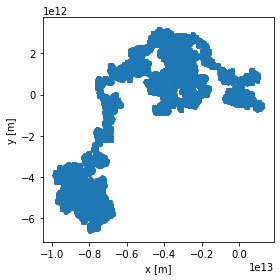

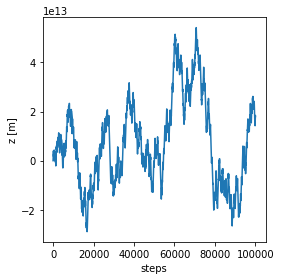

In [6]:
df = pd.read_pickle("data.pkl")
#print(df)
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
vis = Vizualizer(df_time_evolution_observer)
#plot_trajectory_seperated(df_time_evolution_observer)
vis.plot_trajectory(2*10**5)